<a href="https://colab.research.google.com/github/mmartin46/Criminal_Analysis_Project/blob/main/CriminalInvestigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
To analayze the given dataset and use predictive modeling
approaches to make predictions on which demographics
are most vulnerable to certain crimes.

Questions:

1.   Which demographics are most susceptible to be victims of battery charges?
2.   Which age-groups tend to be most vulnerable to sex offending charges?



In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 9.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import altair as alt
from altair import Chart, X, Y, Color, Scale
import datetime as dt
import matplotlib.pyplot as plt
from pandas.core.common import random_state
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

# Data Cleanup Process
The cleanup process of the given dataset involved
dropping columns that didn't contain any value, replacing
empty spaces with underscores, and transforming each column
as its lowercase representative. All of the methods above are used in
the **get_filtered_dataset** algorithm.

Predictive Modeling: Removing the rows would allow more our predictive modeling research to be pursued.

CSV File Dimensions: ( 730990 rows × 15 columns )

In [4]:
def get_filtered_dataset():
  df = pd.read_csv('https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD')
  # Formatting the columns
  df.columns = [str(col).lower() for col in df.columns]
  df.columns = df.columns.str.replace(" ", "_")
  gender = df['vict_sex']

  df.dropna(axis='columns', inplace=True)

  df['vict_sex'] = gender
  df.dropna(axis='rows', inplace=True)

  # Changing the time
  df['date_occ'] = pd.to_datetime(df['date_occ'])
  df['date_rptd'] = pd.to_datetime(df['date_rptd'])
  return df

In [5]:
df = get_filtered_dataset()


In [6]:
df.columns

Index(['dr_no', 'date_rptd', 'date_occ', 'time_occ', 'area', 'area_name',
       'rpt_dist_no', 'part_1-2', 'crm_cd', 'crm_cd_desc', 'vict_age',
       'status', 'status_desc', 'location', 'lat', 'lon', 'vict_sex'],
      dtype='object')

In [7]:
criminal_stats = (df.groupby('crm_cd_desc').count().reset_index())[['crm_cd_desc', 'dr_no']]
criminal_stats.set_index('crm_cd_desc', inplace=True)
criminal_stats.sort_values(by=['dr_no'], inplace=True, ascending=False)

In [8]:
criminal_stats.reset_index(inplace=True)

In [9]:
criminal_stats.head(50)

,crm_cd_desc,dr_no
0,BATTERY - SIMPLE ASSAULT,58879
1,THEFT OF IDENTITY,48145
2,BURGLARY FROM VEHICLE,45992
3,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",45603
4,BURGLARY,45107
5,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",42601
6,THEFT PLAIN - PETTY ($950 & UNDER),38045
7,INTIMATE PARTNER - SIMPLE ASSAULT,37496
8,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,27350
9,ROBBERY,25417


In [10]:
def get_incident_results(NAME):
  ((df[df['crm_cd_desc'].str.contains(str(NAME))].groupby('date_occ').count()).reset_index())[['date_occ', 'dr_no']]

In [11]:
vehicle_incidents = ((df[df['crm_cd_desc'].str.contains('VEHICLE')].groupby('date_occ').count()).reset_index())[['date_occ', 'dr_no']]
felony_incidents = ((df[df['crm_cd_desc'].str.contains('FELONY')].groupby('date_occ').count()).reset_index())[['date_occ', 'dr_no']]
battery_incidents = ((df[df['crm_cd_desc'].str.contains('BATTERY')].groupby('date_occ').count()).reset_index())[['date_occ', 'dr_no']]

# Which demographics are most susceptible to be victims of battery charges?

In [12]:
battery_charges = df[df['crm_cd_desc'].str.contains('BATTERY')]
battery_charges.head()

,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,vict_age,status,status_desc,location,lat,lon,vict_sex
0,10304468,2020-01-08,2020-01-08,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,36,AO,Adult Other,1100 W 39TH PL,34.0141,-118.2978,F
1,190101086,2020-01-02,2020-01-01,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,25,IC,Invest Cont,700 S HILL ST,34.0459,-118.2545,M
28,200815333,2020-10-15,2020-10-15,2000,8,West LA,814,2,624,BATTERY - SIMPLE ASSAULT,50,AO,Adult Other,100 S ACARI DR,34.0701,-118.4679,F
37,200914052,2020-08-27,2020-08-27,1255,9,Van Nuys,935,2,624,BATTERY - SIMPLE ASSAULT,57,IC,Invest Cont,14100 SYLVAN ST,34.1847,-118.4400,F
39,200810920,2020-06-20,2020-06-20,1000,8,West LA,841,2,624,BATTERY - SIMPLE ASSAULT,78,AO,Adult Other,12100 SANTA MONICA BL,34.0423,-118.4656,F


In [13]:
battery_charges.columns

Index(['dr_no', 'date_rptd', 'date_occ', 'time_occ', 'area', 'area_name',
       'rpt_dist_no', 'part_1-2', 'crm_cd', 'crm_cd_desc', 'vict_age',
       'status', 'status_desc', 'location', 'lat', 'lon', 'vict_sex'],
      dtype='object')

In [14]:
batt_charges = (battery_charges.groupby(['vict_age', 'vict_sex']).count()).reset_index()
batt_charges = batt_charges[['vict_age', 'vict_sex', 'date_occ']]

In [15]:
batt_charges = batt_charges.groupby(['vict_age', 'vict_sex']).sum()

In [16]:
batt_charges = batt_charges.reset_index()

In [17]:
male_batt_charges = batt_charges[batt_charges['vict_sex'] == 'M']
female_batt_charges = batt_charges[batt_charges['vict_sex'] == 'F']
batt_charges = batt_charges[batt_charges['vict_sex'] == 'X']

In [18]:
batt_charges

,vict_age,vict_sex,date_occ
2,0,X,998
5,2,X,1
8,3,X,1
23,10,X,2
28,12,X,1
...,...,...,...
222,78,X,1
227,80,X,1
232,82,X,1
243,87,X,1


In [ ]:
fig, ax = plt.subplots()

ax.plot(female_batt_charges['vict_age'], female_batt_charges['date_occ'])
ax.set(title='Battery Victims',
       xlabel='Victim Age',
       ylabel='Number of Occurences')

ax.plot(male_batt_charges['vict_age'], male_batt_charges['date_occ'])
ax.legend(['Female', 'Male'])
plt.show()

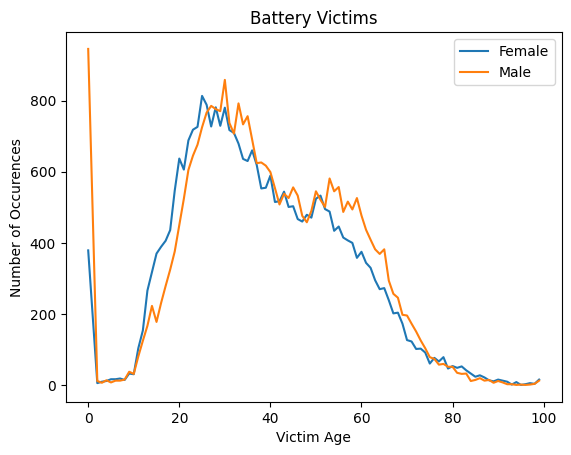

## Battery Statistics

The majority of battery victims among infants tend to be higher in males than females, which places male infants as the most victimized in crimes involving battery.
Quickly following are adults within the 20-30 age range.

In [20]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

X = np.array(male_batt_charges['vict_age']).reshape(-1, 1)
y = np.array(male_batt_charges['date_occ'])



In [21]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

r1 = DecisionTreeRegressor(max_depth=4)
r2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                       n_estimators=100, random_state=997)

r1.fit(X, y)
r2.fit(X, y)

y_1 = r1.predict(X)
y_2 = r2.predict(X)

In [ ]:
color_pal = sns.color_palette('husl', 3)

fig, ax = plt.subplots()

ax.scatter(X, y, color=color_pal[0], label='Training Samples')
ax.plot(X, y_1, color=color_pal[1], label='n_estimators=1', linewidth=2)
ax.plot(X, y_2, color=color_pal[2], label='n_estimators=200', linewidth=2)

ax.set(title='Boosted Decision Tree Regression (Male Battery Victims)',
       xlabel='Victim Age',
       ylabel='Number of Occurences')

ax.legend()
plt.show()

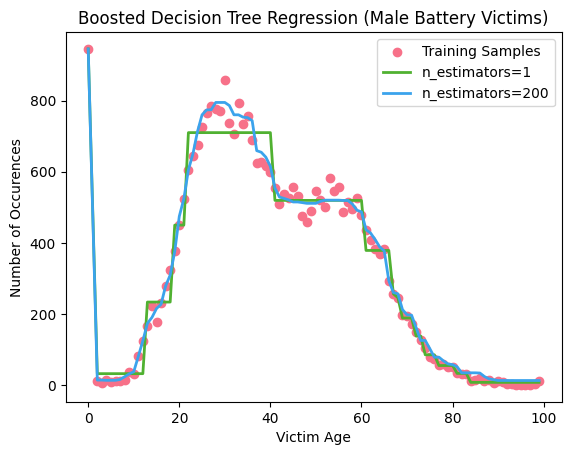

## Boosting Tree Regression


The Boosting Tree Regression algorithm allows our prediction to be more accurate.
Utilizing the algorithm, we are able to find
that male infants and adults within the 20-40 age bracket are the most common victims within battery incidents.

### Common Victims:
* Male Infants (0-2)
* Male Adults (20-40)
* Male Adults (40-60)

In [23]:
battdf = df[df['crm_cd_desc'].str.contains('BATTERY')]

In [24]:
battdf

,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,vict_age,status,status_desc,location,lat,lon,vict_sex
0,10304468,2020-01-08,2020-01-08,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,36,AO,Adult Other,1100 W 39TH PL,34.0141,-118.2978,F
1,190101086,2020-01-02,2020-01-01,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,25,IC,Invest Cont,700 S HILL ST,34.0459,-118.2545,M
28,200815333,2020-10-15,2020-10-15,2000,8,West LA,814,2,624,BATTERY - SIMPLE ASSAULT,50,AO,Adult Other,100 S ACARI DR,34.0701,-118.4679,F
37,200914052,2020-08-27,2020-08-27,1255,9,Van Nuys,935,2,624,BATTERY - SIMPLE ASSAULT,57,IC,Invest Cont,14100 SYLVAN ST,34.1847,-118.4400,F
39,200810920,2020-06-20,2020-06-20,1000,8,West LA,841,2,624,BATTERY - SIMPLE ASSAULT,78,AO,Adult Other,12100 SANTA MONICA BL,34.0423,-118.4656,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743771,230404317,2023-01-09,2023-01-09,1745,4,Hollenbeck,457,2,624,BATTERY - SIMPLE ASSAULT,38,IC,Invest Cont,2800 CINCINNATI ST,34.0453,-118.2019,M
743787,231209545,2023-04-04,2023-04-04,910,12,77th Street,1233,2,624,BATTERY - SIMPLE ASSAULT,34,IC,Invest Cont,1600 W 59TH ST,33.9875,-118.3046,M
743789,230906452,2023-03-05,2023-03-04,1735,9,Van Nuys,926,2,624,BATTERY - SIMPLE ASSAULT,52,AO,Adult Other,6700 HAZELTINE AV,34.1926,-118.4400,F
743798,230509679,2023-06-07,2023-06-07,2045,5,Harbor,529,2,624,BATTERY - SIMPLE ASSAULT,63,AO,Adult Other,ANAHEIM ST,33.7803,-118.2573,M


In [25]:
batt_stats = ((battdf.groupby(by=['crm_cd_desc', 'date_occ']).count()).reset_index()).iloc[:, :3]

In [26]:
batt_stats

,crm_cd_desc,date_occ,dr_no
0,BATTERY - SIMPLE ASSAULT,2020-01-01,74
1,BATTERY - SIMPLE ASSAULT,2020-01-02,43
2,BATTERY - SIMPLE ASSAULT,2020-01-03,42
3,BATTERY - SIMPLE ASSAULT,2020-01-04,59
4,BATTERY - SIMPLE ASSAULT,2020-01-05,49
...,...,...,...
3417,BATTERY WITH SEXUAL CONTACT,2023-06-10,1
3418,BATTERY WITH SEXUAL CONTACT,2023-06-11,3
3419,BATTERY WITH SEXUAL CONTACT,2023-06-13,2
3420,BATTERY WITH SEXUAL CONTACT,2023-06-14,1


In [ ]:
Chart(batt_stats[(batt_stats['date_occ'].dt.year == 2023)]).mark_area().encode(
    x=alt.X('date_occ:T', title='Date of Occurance'),
    y=alt.Y('dr_no', title='Frequency of Occurances'),
    color='crm_cd_desc'
).properties(
    title='Battery Victims'
).interactive()

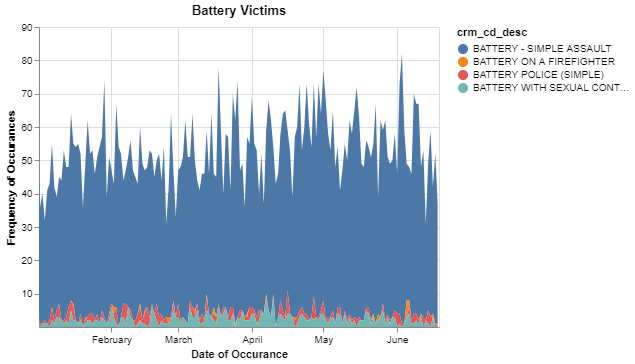



In the first 6 months of 2023 alone, the visualization
concludes that most of the given battery charges are in the
form of simple assault.

In [28]:
sex_off = df[df['crm_cd_desc'].str.contains('SEX')]

In [29]:
sex_off = (((sex_off.groupby(by=['vict_sex', 'vict_age']).count()).iloc[:, :1]).reset_index())

# Which age-groups tend to be most vulnerable to sex offenders?


In [30]:
sex_off = sex_off[sex_off['vict_age'] >= 0]

In [31]:
male_sex_off = sex_off[sex_off['vict_sex'] == 'M']
female_sex_off = sex_off[sex_off['vict_sex'] == 'F']

In [ ]:
fig, ax = plt.subplots()

ax.plot(male_sex_off['vict_age'], male_sex_off['dr_no'])
ax.plot(female_sex_off['vict_age'], female_sex_off['dr_no'])
ax.set_title("Sex Offender Victims")

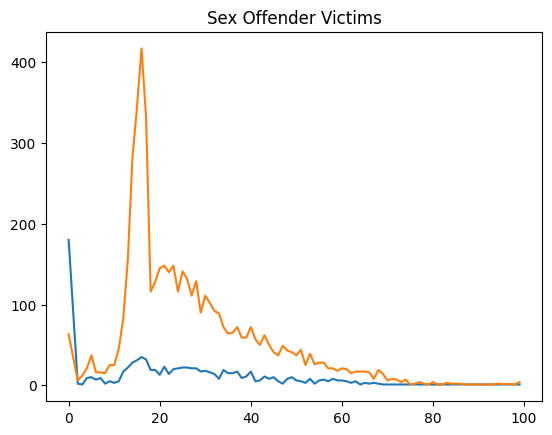

## Males vs Females

We are able to notice that the male victims seem to lower frequency of sexual assault than the opposite gender and it looks like a majority of the accussed
cases peak at just below age 20 for females.


In [33]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [34]:
X = np.array(female_sex_off['vict_age']).reshape(-1, 1)
y = np.array(female_sex_off['dr_no'])

# Preventing signal leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=997)

## Neural Networks

Using neural networks will allow us to predict the likelyhood
of which age category is most likely to be a victim for sexual
assault cases.

In [ ]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.01,
    patience=520,
    restore_best_weights=True
)

model = keras.Sequential([
    layers.Dense(128, activation='relu', name='layer_1'),
    layers.Dense(64, activation='relu', name='layer_2'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae'
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)

history_df = pd.DataFrame(history.history)

Minimum Validation Loss: 49.19


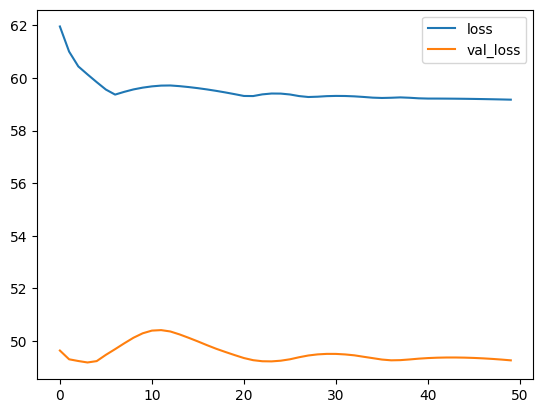

In [36]:
# Minimizing the validation loss
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.2f}".format(history_df['val_loss'].min()))

In [37]:
print("Evaluating Test Data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("Test Loss, Test Accuracy:", results)

Evaluating Test Data
1/1 [==============================] - 0s 31ms/step - loss: 49.2663
Test Loss, Test Accuracy: 49.266265869140625


In [38]:
X_predict = model.predict(X_test)



2/2 [==============================] - 0s 6ms/step


<ipython-input-42-845e45908118>:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax.stem(X_predict, y_test, use_line_collection=True, markerfmt='C7o', linefmt='C7-',


Text(0.5, 1.0, 'Sex Offender Victims')

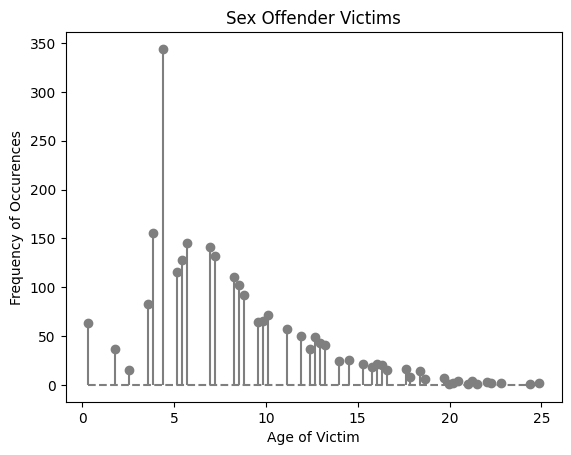

In [42]:
fig, ax = plt.subplots()
#ax.plot(female_sex_off['vict_age'], female_sex_off['dr_no'])
ax.stem(X_predict, y_test, use_line_collection=True, markerfmt='C7o', linefmt='C7-',
        basefmt='C7--')
ax.set_ylabel('Frequency of Occurences')
ax.set_xlabel('Age of Victim')
ax.set_title("Sex Offender Victims")


## Predictive Analysis
The visualization shows us that the number of sex offender victims tends to have a higher frequency towards minors than any other age group.
Specifically it seems that the neural network made a prediction that
females from approximately 3-16 tend to have a higher frequency of becoming
sexual offender victims than otherwise.

In [367]:
df

,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,vict_age,status,status_desc,location,lat,lon,vict_sex
0,10304468,2020-01-08,2020-01-08,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,36,AO,Adult Other,1100 W 39TH PL,34.0141,-118.2978,F
1,190101086,2020-01-02,2020-01-01,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,25,IC,Invest Cont,700 S HILL ST,34.0459,-118.2545,M
2,200110444,2020-04-14,2020-02-13,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,0,AA,Adult Arrest,200 E 6TH ST,34.0448,-118.2474,X
3,191501505,2020-01-01,2020-01-01,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),76,IC,Invest Cont,5400 CORTEEN PL,34.1685,-118.4019,F
4,191921269,2020-01-01,2020-01-01,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",31,IC,Invest Cont,14400 TITUS ST,34.2198,-118.4468,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743812,231510379,2023-05-29,2023-05-25,1100,15,N Hollywood,1548,2,662,"BUNCO, GRAND THEFT",25,IC,Invest Cont,5300 DENNY AV,34.1667,-118.3643,M
743813,231604807,2023-01-27,2023-01-26,1800,16,Foothill,1663,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",23,IC,Invest Cont,12500 BRANFORD ST,34.2466,-118.4054,M
743814,231606525,2023-03-22,2023-03-22,1000,16,Foothill,1602,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",25,IC,Invest Cont,12800 FILMORE ST,34.2790,-118.4116,F
743815,231210064,2023-04-12,2023-04-12,1630,12,77th Street,1239,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",29,IC,Invest Cont,6100 S VERMONT AV,33.9841,-118.2915,M


# Which demographic factors have a strong impact on shoplifting victims?

In [391]:
def filter_range_ds(SETTING, filter_start, filter_end, column):
  """Cleans up the shoplifters dataset and gives it a specified range.
     SETTING - set the type of felony you want to see.
     filter_start - start with a specified age
     filter_end - end with a specified age
     column - column checked
  """
  s_lifters = df[df['crm_cd_desc'].str.contains(SETTING)]
  s_lifters = s_lifters[(s_lifters['vict_sex'] != 'X') & (s_lifters['vict_sex'] != 'H') & (s_lifters[column] != 0)]
  s_lifters = s_lifters[(s_lifters[column] >= filter_start) & (s_lifters[column] <= filter_end)]
  s_lifters = ((s_lifters.groupby([column, 'vict_sex']).count()).iloc[:, :1]).reset_index()
  return s_lifters

In [392]:
shop_lifters = filter_range_ds('SHOPLIFTING', 16, 60, 'vict_age')

In [393]:
shop_lifters

,vict_age,vict_sex,dr_no
0,16,M,1
1,17,F,1
2,17,M,1
3,18,F,3
4,18,M,13
...,...,...,...
84,58,M,9
85,59,F,2
86,59,M,16
87,60,F,2


In [396]:
import altair as alt

alt.Chart(shop_lifters, title='Shoplifting Victims').mark_area(
    point = {
        "filled": False,
        "fill": "white"
    }
).encode(
    alt.X("vict_age", title='Victim Age'),
    alt.Y('dr_no', title='# of Victims'),
    alt.Color('vict_sex')
).properties(
    width=1600,
    height=500
)

alt.Chart(...)

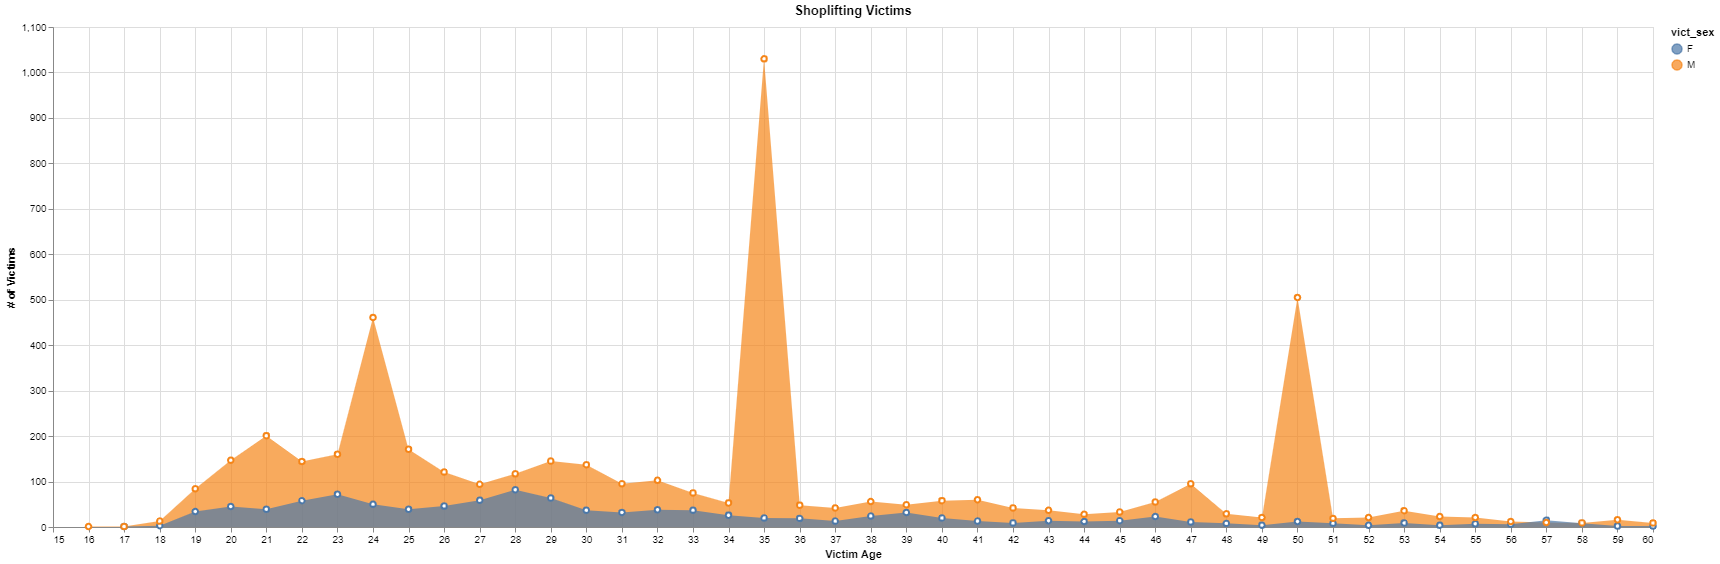

### Male Female Ratio
The visualization shows that males tend to have more
of a tendency of being a shoplifting victim than
females. We are also able to notice that males
also tend to have a higher frequency of peaks as they age.

Male victims tend to have a strong increase of
becoming shoplifting victims around their
- early-mid 20s
- mid 30s
- early 50s.

Females on the other hand are most vulnerable to these types
of crimes throughout their 20s.